# <span style = 'color: red'>**Práctica uno.** Aprendizaje de máquina. *Redes neuronales*</span>

# ***Parte uno.*** **CNN y LeNET5.**

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda el desarrollo del **primer problema** de la *práctica dos* del curso de **Aprendizaje de Máquina**.

A continuación, se abren los paquetes que se usarán para dar solución al problema propuesto.

**Anotación.** Este *notebook* está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de GitHub [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/tree/main), y en particular, a este cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/blob/main/Cuadernos/01_cnn_lenet5.ipynb).

In [1]:
#
# Apertura de paquetes generales relevantes
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Apertura de paquetes para el trabajo con RNN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, InputLayer

# Otras librerías analíticas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.losses import SparseCategoricalCrossentropy

# Otras librerías
import pydot
from tensorflow.keras.utils import plot_model

## <span style = 'color: cyan'>***1.1.***</span> Apertura del marco de datos y revisión inicial

In [2]:
#
# Apertura
direcc = '../Datos/Digit/dataDigit.csv'
digits = pd.read_csv(direcc)

# Dimensión
print(f'El marco de datos tiene {digits.shape[0]} filas y {digits.shape[1]} columnas.')

El marco de datos tiene 42000 filas y 785 columnas.


Nótese que el marco de datos contiene $785$ columnas. Esto obedece a que cada imagen está compuesta por $28 \ \times 28 = 784$ píxeles. El píxel restante corresponde a la etiqueta del dígito que se pretende representar. Además, se tienen un total de $42,000$ observaciones.

En teoría, este marco de datos debería estar compuesto únicamente de columnas de tipo entero. Para verificar esto, se va a crear una lista que coleccione el nombre de todas las columnas que tienen esta tipología de dato. Así, si es correcto, el tamaño de la lista debe ser de exactamente $785$ elementos.

In [3]:
#
# Columnas de tipo entero
int_cols = [col for col in digits.columns if digits[col].dtype == 'int64']
print(f'El marco de datos tiene {len(int_cols)} columnas de tipo entero.')

El marco de datos tiene 785 columnas de tipo entero.


Igualmente, se va a verificar que el marco de datos esté completo:

In [4]:
# Verificación de que el marco de datos esté completo
digits.isna().sum().sum() == 0

np.True_

## <span style = 'color: cyan'>***1.2.***</span> Visualización

Ahora, se graficarán dieciséis instancias aleatorias del marco de datos.

In [5]:
#
# Separación de objetivo y características
X = digits.drop('label', axis=1)
y = digits['label']

In [6]:
#
# Semilla para pseudoaleatorización
np.random.seed(103)
indices = np.random.choice(X.shape[0], size=16, replace=False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

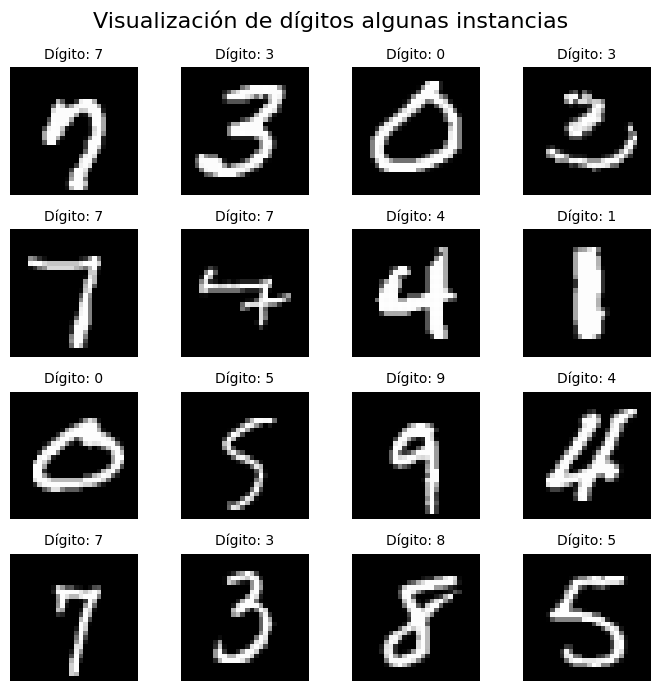

In [7]:
#
# Visualización

fig1, axes1 = plt.subplots(4, 4, figsize=(7, 7), )
axes1 = axes1.flatten()
for digito, eje in enumerate(axes1):
    imagen = X_sample.iloc[digito].values.reshape(28, 28)
    eje.imshow(imagen, cmap='gray')
    eje.set_title(f'Dígito: {y_sample.iloc[digito]}', fontsize=10,)
    eje.axis('off')
plt.suptitle('Visualización de dígitos algunas instancias', fontsize=16, )
plt.tight_layout()
plt.show()

El objetivo, pues, es que a partir de la coloración de cada uno de los píxeles, se pueda predecir a qué dígito está asociada una imagen particular.

## <span style = 'color: cyan'>***1.3.***</span> Estructuración del marco de datos


Ahora bien, teniendo en cuenta que los datos tienen una configuración $28 \times 28$, primero se le agregarán dos pares de columnas de ceros a la izquierda y a la derecha (un par a cada lado) para alcanzar la configuración $32 \times 32$ que requiere un red de tipo LeNET-5.

In [8]:
#
# Estructuración del marco de datos
X_np = X.to_numpy()
X_reest = X_np.reshape(-1, 28, 28)

# Padding
X_pad = np.pad(X_reest, ((0, 0), (2, 2), (2, 2)), mode='constant', )

# Adición del canal
X_pad = np.expand_dims(X_pad, axis=-1)

X_pad.shape

(42000, 32, 32, 1)

## <span style = 'color: cyan'>***1.4.***</span> Normalización

Para facilitar el ajuste del modelo en la red neuronal, se normalizarán las entradas de la matriz de diseño. Para ello, al tratarse de datos asociados a imágenes, basta con dividir las entradas entre $255$.

In [9]:
#
# Normalización
X_scaled = X_pad / 255.0

## <span style = 'color: cyan'>***1.4.***</span> Configuración de la arquitectura

A continuación, se definirá la arquitectura de la red neuronal siguiendo las indicaciones de la guía:

In [10]:
#
# Definición del modelo LeNET-5
modelo = Sequential()

# 0. Entrada
modelo.add(InputLayer(input_shape=(32, 32, 1)))

# 1. Convolucional
modelo.add(Conv2D(filters=6, kernel_size=(5, 5, ), activation='relu', ))

# 2. Average pooling
modelo.add(AveragePooling2D(pool_size=(2, 2, ), ))

# 3. Convolucional
modelo.add(Conv2D(filters=16, kernel_size=(5, 5, ), activation='relu', ))

# 4. Average pooling
modelo.add(AveragePooling2D(pool_size=(2, 2, ), ))

# 4.1. Aplanamiento
modelo.add(Flatten())

# 5. Densa
modelo.add(Dense(units=120, activation='relu', ))

# 6. Densa
modelo.add(Dense(units=84, activation='relu', ))

# 7. Densa de salida
modelo.add(Dense(units=10, activation='softmax', ))

/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Visualmente, el modelo de red neuronal definido luce como sigue:

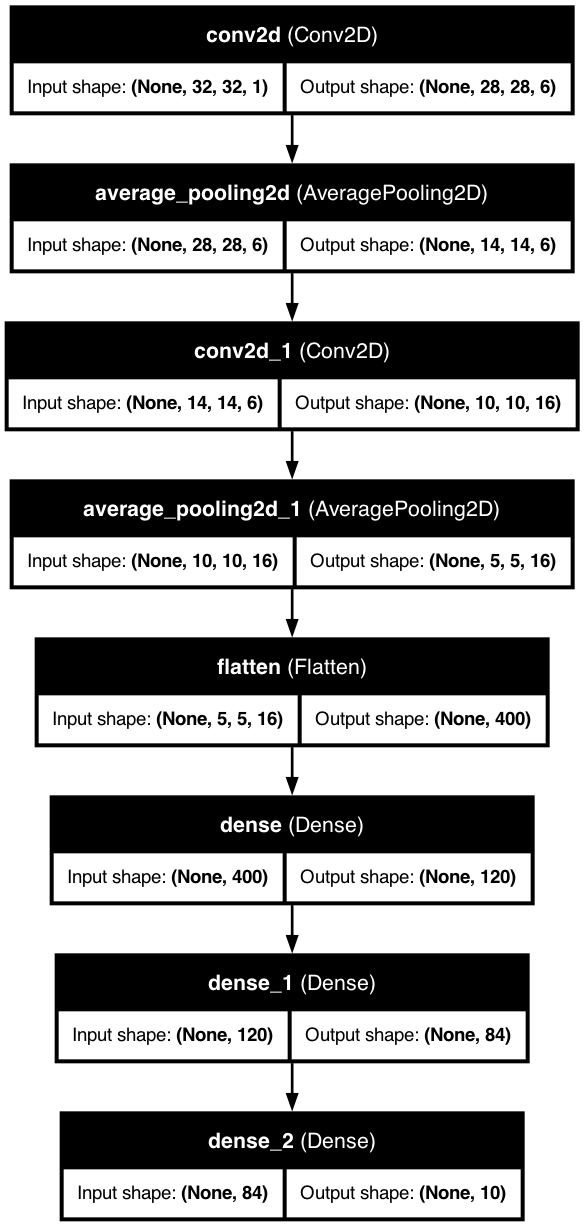

In [12]:
plot_model(
    modelo,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

In [13]:
#
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
)

# Parámetros para entrenamiento
modelo.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

## <span style = 'color: cyan'>***1.5.***</span> Entrenamiento de la red

Para entrenar el modelo, primero se van a dividir los datos en conjuntos de entrenamiento y validación.

In [14]:
#
# División de datos
X_tr, X_ts, y_tr, y_ts = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=103,
)

In [ ]:
# Entrenamiento
historia = modelo.fit(
    X_tr,
    y_tr,
    epochs=50,
    validation_split=0.1,
    callbacks=[callback],
)